In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
freq_tmr = 84e6     #[Hz]
full_step = 1.8      #[deg/step]
micro_steps = 1/8

alpha = full_step * micro_steps #[deg/pulse]
alpha_rad = (alpha * np.pi/180)

In [21]:
def test_numeric_method(func, title, funcArgs = None):
    x_vals_test = np.linspace(-1,1,1000)
    y_vals_test = list()

    if funcArgs:
        for x in x_vals_test:
            y_vals_test.append(func(x, funcArgs))
    else:
        for x in x_vals_test:
            y_vals_test.append(func(x))

    plt.plot(x_vals_test,y_vals_test)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('~ -arcsin(x)')
    plt.grid()

In [22]:
def generate_arcsin_LUT(N):
    x_vals = np.linspace(0,1,N)
    y_vals = -np.arcsin(x_vals)
    return x_vals, y_vals

In [23]:
## https://www.geeksforgeeks.org/dsa/binary-search/
def binarySearch(arr, x):
    low = 0
    high = len(arr) - 1
    mid = low + (high - low) // 2
    while low <= high:
        # Check if x is present at mid
        if arr[mid] == x:
            return mid

        # If x is greater, ignore left half
        elif arr[mid] < x:
            low = mid + 1

        # If x is smaller, ignore right half
        else:
            high = mid - 1

        mid = low + (high - low) // 2
    # If we reach here, then the element
    # was not present
    return mid

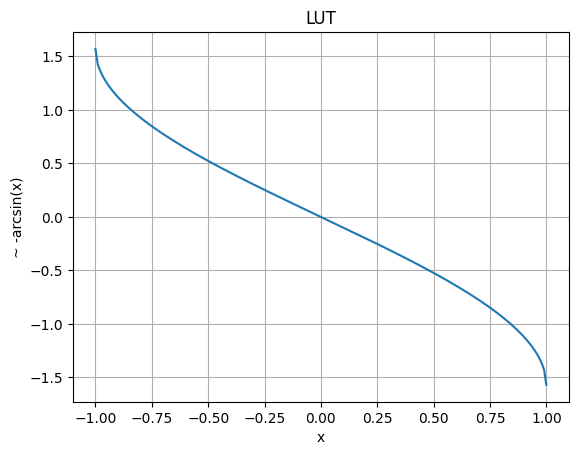

In [24]:
def lookup_arcsin(x, LUT):
    x_vals = LUT[0]
    y_vals = LUT[1]

    sign = 1

    if x < 0:
        sign = -1
        x = -x
    
    if x <= x_vals[0]:
        return sign * y_vals[0]
    elif x >= x_vals[-1]:
        return sign * y_vals[-1]
    
    #idx = np.searchsorted(x_vals, x) - 1
    #idx = binarySearch(x_vals, x) - 1
    idx = np.searchsorted(x_vals, x)-1
    x0, x1 = x_vals[idx], x_vals[idx+1]
    y0, y1 = y_vals[idx], y_vals[idx+1]
    
    #linear approximation

    dy_dx = (y1 - y0) / (x1 - x0)
    dt = x - x0
    y = y0 + (dy_dx * dt)

    return sign * y

LUT_TEST = generate_arcsin_LUT(100)
test_numeric_method(lookup_arcsin, title = 'LUT', funcArgs = LUT_TEST)

In [25]:
def calculate_tk(arcsin_approx, LUT, k, Theta_rad, T, alpha_rad):
    return (arcsin_approx( 1 - 2 * (k * alpha_rad)/Theta_rad, LUT) + np.pi/2) * T/np.pi

In [26]:
Theta = 90          #[deg]
T = 2

n_steps = int(Theta/alpha)
Theta_rad = np.deg2rad(Theta)


LUT_res = 100
LUT = generate_arcsin_LUT(LUT_res)

times_LUT = []

for k in range(n_steps+1):
    t_k_LUT = calculate_tk(lookup_arcsin, LUT, k, Theta_rad, T, alpha_rad)

    times_LUT.append(t_k_LUT)

d_times_LUT = np.diff(times_LUT)

d_times_summed_LUT = [] # to check the theory

integrated_speed_LUT = []

# speed in rad/sec
speed_LUT = alpha_rad / d_times_LUT

#sum for LUT
sum = 0
sum_int = 0
for dt in d_times_LUT:
    sum += dt
    d_times_summed_LUT.append(sum)

    sum_int += (alpha_rad/dt)*dt
    integrated_speed_LUT.append(sum_int)

In [27]:
def T_omega_texts(ax1: plt.axes, ax2: plt.axes, times: np.array, omegas: np.array, thetas: np.array, d_times_summed: np.array) -> None:
    T_text = r"$T= $" + f"{np.round(np.nanmax(times), 3)}" + r" $[s]$"
    ax1.text(np.nanmax(times) - 0.09, np.nanmax(thetas)/2, 
            T_text,
            ha = 'right',
            va = 'center',
            rotation = 'vertical',
            bbox=dict(facecolor='red', alpha=0.3, boxstyle = 'round', ec = 'red')
            )

    omega_max_text = r"$\omega_{max} = $" + f"{np.round(np.nanmax(omegas), 3)}" + r" $[\frac{rad}{s}]$"
    ax2.text(np.nanmax(d_times_summed)/2, np.nanmax(omegas)+0.07, 
            omega_max_text,
            ha = 'center',
            bbox=dict(facecolor='blue', alpha=0.3, boxstyle = 'round', ec = 'blue')
            )

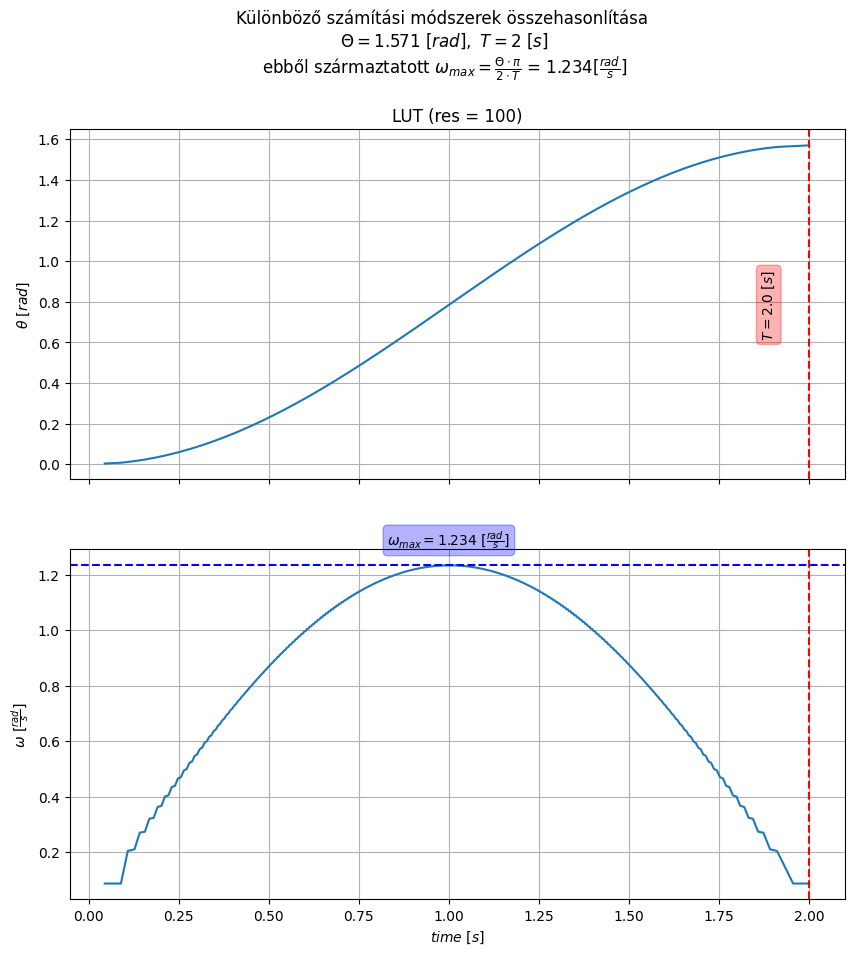

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)


omega_max_calculated = (Theta_rad * np.pi )/( 2 * T )

title = "Különböző számítási módszerek összehasonlítása \n" + \
        fr"$\Theta = {np.round(Theta_rad, 3)} \ [rad], \ T = {T} \ [s]$" + "\n" + \
        r"ebből származtatott $\omega_{max} = \frac{\Theta \cdot \pi}{2 \cdot T}$" + f" = {np.round(omega_max_calculated, 3)}" + r"$[\frac{rad}{s}]$"

fig.suptitle(title, y = 1)

fig.set_size_inches(10,10)
#fig.set_dpi(700)



ax1.plot(d_times_summed_LUT, integrated_speed_LUT)
ax2.plot(d_times_summed_LUT, speed_LUT)

ax2.axhline(speed_LUT.max(), color = 'blue', ls = '--')
ax1.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')
ax2.axvline(d_times_summed_LUT[-1], color = 'red', ls = '--')

T_omega_texts(ax1, ax2, d_times_summed_LUT, speed_LUT, integrated_speed_LUT, d_times_summed_LUT)
ax1.set_title(f"LUT (res = {LUT_res})")

ax1.set_ylabel(r'$\theta\ [rad]$')
ax2.set_ylabel(r'$\omega\ [\frac{rad}{s}]$')

for ax in fig.get_axes():
    ax.grid()
    ax.set_xlabel(r'$time\ [s]$')
    ax.label_outer()

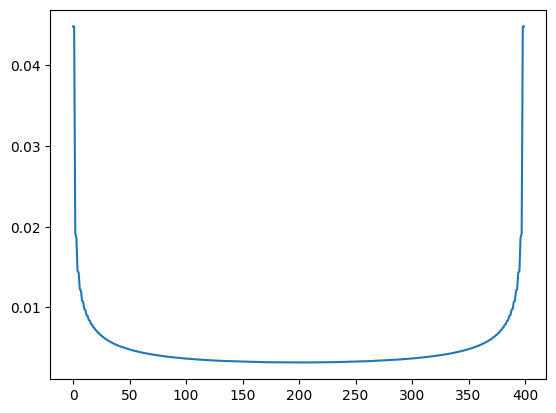

In [29]:
ARR_vals = timer_values = (d_times_LUT*freq_tmr)-1

plt.plot(d_times_LUT)